In [ ]:
# GPU 확인 및 설정
import tensorflow as tf

# GPU 사용 가능 여부 확인
print("TensorFlow 버전:", tf.__version__)
print("\n사용 가능한 물리적 디바이스:")
physical_devices = tf.config.list_physical_devices()
for device in physical_devices:
    print(f"  - {device}")

# GPU 디바이스 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ GPU 발견: {len(gpus)}개")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # GPU 메모리 증가 설정 (필요한 만큼만 사용)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("\n✓ GPU 메모리 증가 설정 완료")
    except RuntimeError as e:
        print(f"\n경고: GPU 메모리 설정 중 오류: {e}")
    
    # GPU 정보 출력
    print("\nGPU 상세 정보:")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}:")
        print(f"    - 이름: {gpu.name}")
        print(f"    - 디바이스 타입: {gpu.device_type}")
else:
    print("\n✗ GPU를 찾을 수 없습니다. CPU를 사용합니다.")

# 현재 사용 중인 디바이스 확인
print(f"\n현재 기본 디바이스: {tf.config.list_logical_devices()}")

In [2]:
import tensorflow as tf
from utils.dataset_functions import create_dataset, unwrap_client_data, create_dataset_lazy, create_tf_dataset
from utils.image_processing import *
from utils.unet import initialize_unet
from utils.federated_averaging import federated_averaging
from utils.visualization import visualize_results_testset

In [3]:
imagePath0 = 'merged_data/0/' # Post Spreading Images
imagePath1 = 'merged_data/1/' # Post Fusion Images
npyPath = 'merged_data/annotations/' # Annotations

# merged_data 폴더의 파일들을 8개 클라이언트에 균등하게 분배
# 총 3744개 파일을 8개 클라이언트에 각각 468개씩 분배
total_files = 693
num_clients = 8
files_per_client = total_files // num_clients

clientIdentifierDict = {}
start = 1

for i in range(1, num_clients + 1):
    if i < num_clients:
        end = start + files_per_client - 1
    else:
        end = total_files  # 마지막 클라이언트는 나머지 모든 파일 포함
    
    # 파일 이름 리스트 생성 (000001, 000002, ... 형식)
    file_list = [f'{j:06d}' for j in range(start, end + 1)]
    clientIdentifierDict[f'client{i}'] = file_list
    print(f'client{i}: {start:06d} ~ {end:06d} ({len(file_list)}개 파일)')
    start = end + 1

# Lazy loading 방식: 파일 경로만 저장 (데이터는 학습 시점에 로드)
filePathDict, imagePath0, imagePath1, npyPath, tileSize = create_dataset_lazy(
    clientIdentifierDict, imagePath0, imagePath1, npyPath, tileSize=128
)

print('\n파일 경로만 저장 완료. 데이터는 학습 시점에 로드됩니다.')

client1: 000001 ~ 000086 (86개 파일)
client2: 000087 ~ 000172 (86개 파일)
client3: 000173 ~ 000258 (86개 파일)
client4: 000259 ~ 000344 (86개 파일)
client5: 000345 ~ 000430 (86개 파일)
client6: 000431 ~ 000516 (86개 파일)
client7: 000517 ~ 000602 (86개 파일)
client8: 000603 ~ 000693 (91개 파일)
client1: 86개 파일
client2: 86개 파일
client3: 86개 파일
client4: 86개 파일
client5: 86개 파일
client6: 86개 파일
client7: 86개 파일
client8: 91개 파일

파일 경로만 저장 완료. 데이터는 학습 시점에 로드됩니다.


In [4]:
trainClients = ['client1', 'client2', 'client3', 'client4', 
                'client5', 'client7', 'client8']
testClients = ['client6']

clientIDs, NCLIENTS = trainClients, len(trainClients)

Client Data is stored in two separate dictionaries, one for tiled image tensors (X) and other for segmentation masks (Y). Both dictionaries are keyed by `clientID`.

Training Dictionaries - `imageDict`(X) and `segMaskDict`(Y)

Testing Dictionaries - `imageDictTest`(X) and `segMaskDictTest`(Y)

In [5]:
# Train Data - tf.data.Dataset 생성 (lazy loading)
# 학습 시점에 데이터를 로드하므로 메모리 사용량이 크게 줄어듭니다
# 주의: LOCAL_BATCH_SIZE는 Cell 6에서 정의되므로, Cell 6을 먼저 실행하거나 여기서 정의해야 합니다.
# 여기서는 기본값 32를 사용합니다. Cell 6에서 다른 값을 사용하려면 여기서도 동일한 값을 사용하세요.
batch_size_for_dataset = 32  # Cell 6의 LOCAL_BATCH_SIZE와 동일하게 설정
imageDict, segMaskDict = {}, {}

print('학습용 데이터셋 생성 중...')
for clientID in trainClients:
    dataset, dataset_size = create_tf_dataset(
        filePathDict[clientID], 
        imagePath0, imagePath1, npyPath, tileSize,
        batch_size=batch_size_for_dataset, shuffle=True
    )
    imageDict[clientID] = dataset
    segMaskDict[clientID] = dataset_size  # 데이터셋 크기 저장 (가중 평균 계산용)
    print(f'  {clientID}: {dataset_size}개 타일')

# Test Data - 테스트는 빠르게 하기 위해 미리 로드 (선택사항)
# 테스트 데이터도 lazy loading을 원하면 아래 주석을 해제하고 기존 코드를 주석 처리
from utils.dataset_functions import create_dataset

# 테스트용으로만 데이터를 미리 로드 (선택사항)
testClientIdentifierDict = {clientID: filePathDict[clientID] for clientID in testClients}
datasetImageDictTest, datasetMaskDictTest = create_dataset(
    testClientIdentifierDict, imagePath0, imagePath1, npyPath, tileSize=128
)

imageDictTest, segMaskDictTest = {}, {}
for clientID in testClients:
    imageDictTest[clientID] = datasetImageDictTest[clientID]
    segMaskDictTest[clientID] = datasetMaskDictTest[clientID]

# unwrap test data from dictionary for easier model evaluation
testImages, testMasks = unwrap_client_data(imageDictTest, segMaskDictTest, testClients)
print('테스트 데이터 준비 완료')

학습용 데이터셋 생성 중...
  client1: 2150개 타일
  client2: 2150개 타일
  client3: 8950개 타일
  client4: 12350개 타일
  client5: 2150개 타일
  client7: 2150개 타일
  client8: 2275개 타일

client6...
  처리 중: 50/86 파일 완료 (현재 타일 수: 1250)
  처리 중: 86/86 파일 완료 (현재 타일 수: 2150)
Contains 86 images...
Tiled Image Tensor Shape:  (2150, 128, 128, 2)
Tiled Mask Shape:  (2150, 128, 128)
테스트 데이터 준비 완료


In [6]:
# Set hyperparameters for FL
# For demonstration, we use only 2 server rounds with 5 local epochs
SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE, LOCAL_LEARNING_RATE = 2, 5, 32, 8e-05

# Initialize the global model
model = initialize_unet()

Model: "u-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 4, 4, 512) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 512) │          0 │ max_pooling2d_4[… │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 512) │    262,656 │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 1024)             │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 512) │  4,719,104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    131,328 │ up_sampling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_7[0][0], 

 Total params: 8,291,907 (31.63 MB)

 Trainable params: 8,291,907 (31.63 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Run (simulate) FL
# Please use GPU/Colab to avoid very long training time
# https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index
# https://colab.research.google.com/notebooks/gpu.ipynb

model, serverWeights, lossDict, testLoss, accuracyDict, testAccuracy = federated_averaging(model,
                        SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE,
                        LOCAL_LEARNING_RATE,
                        clientIDs, imageDict, segMaskDict,
                        testImages, testMasks)

------ Server Epoch 0 ------
Running local updates for client1...
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6589 - loss: 0.8763
Epoch 2/5


d:\iot\FLAM\venv311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


68/68 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8068 - loss: 0.4574
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8700 - loss: 0.3196
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8891 - loss: 0.2834
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8969 - loss: 0.2650
Saving local updates for client1...
Running local updates for client2...
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6832 - loss: 0.8380
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8331 - loss: 0.4038
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 66s 958ms/step - accuracy: 0.9024 - loss: 0.2532
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 64s 920ms/step - accuracy: 0.9226 - loss: 0.2060
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 63s 912ms/step - accuracy: 0.9293 - loss: 0.1878
Saving local updates for client2...
Running local updates for client3...
Epoch 1/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 272s 946ms/step - accuracy: 0.9481 - loss: 0.2411
Epoch 2/5
280/280 ━

In [8]:
# 학습 완료된 모델 저장
import os

# saved_models 폴더가 없으면 생성
os.makedirs('saved_models', exist_ok=True)

# 파일명 생성: FL_ServerRounds_LocalEpochs_BatchSize_LearningRate_TestSet.h5
# 예: FL_2_5_32_8e05_HoldoutPart06.h5
test_set_name = ''.join([c.replace('client', '') for c in testClients])  # '6'
if len(test_set_name) == 1:
    test_set_name = '0' + test_set_name  # '06'

# Learning rate를 문자열로 변환 (8e-05 -> 8e05)
lr_str = f"{LOCAL_LEARNING_RATE:.0e}".replace('-', '').replace('+', '').replace('.0', '')

model_filename = f'saved_models/FL_{SERVER_ROUNDS}_{LOCAL_EPOCHS}_{LOCAL_BATCH_SIZE}_{lr_str}_HoldoutPart{test_set_name}.h5'

# 모델 저장
print(f'모델 저장 중: {model_filename}')
model.save(model_filename)
print(f'모델 저장 완료!')

# 최종 테스트 성능 출력
print(f'\n최종 테스트 성능:')
print(f'  Loss: {testLoss[-1]:.4f}')
print(f'  Accuracy: {testAccuracy[-1]:.4f}')


모델 저장 중: saved_models/FL_2_5_32_8e05_HoldoutPart06.h5


모델 저장 완료!

최종 테스트 성능:
  Loss: 0.0684
  Accuracy: 0.9786


For client6...
000431
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step
MeanIoU= 0.719


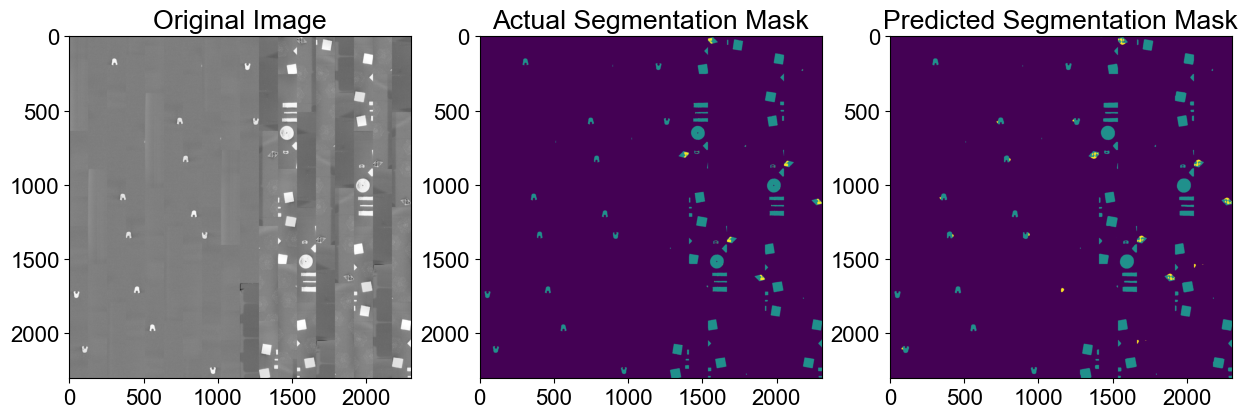

000432
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step
MeanIoU= 0.69


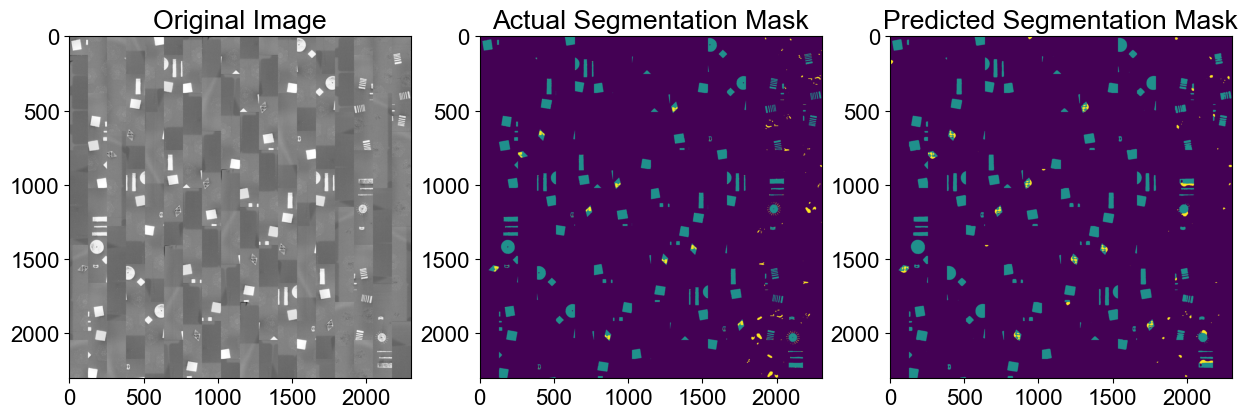

000433
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step
MeanIoU= 0.615


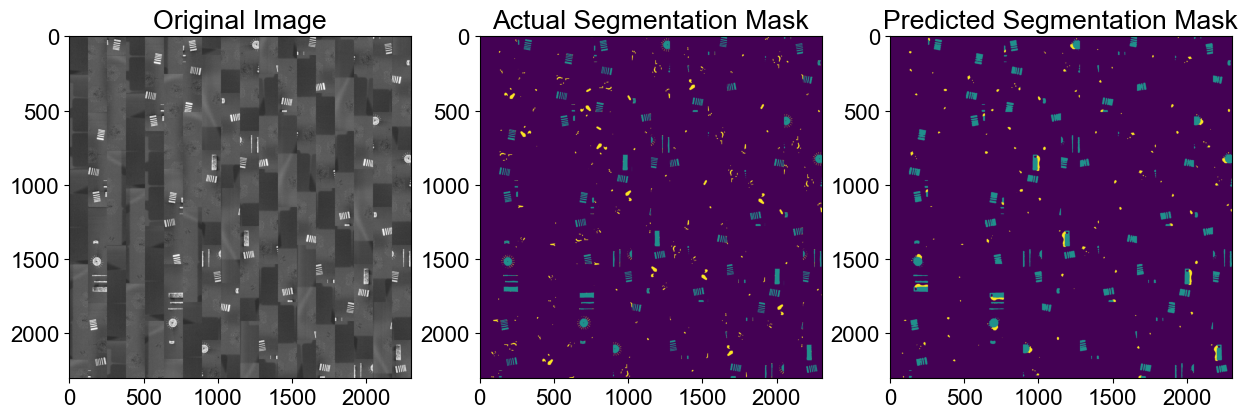

000434
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step
MeanIoU= 0.608


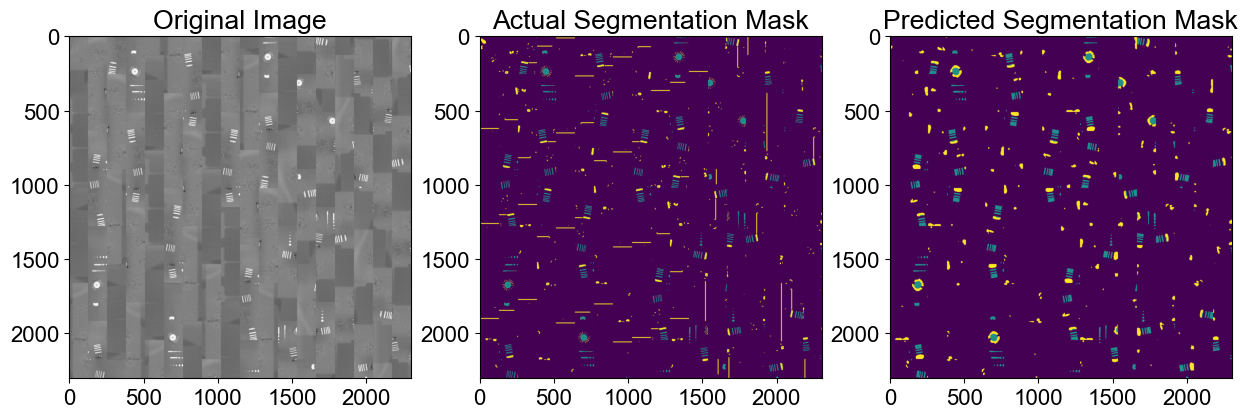

000435
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step
MeanIoU= 0.619


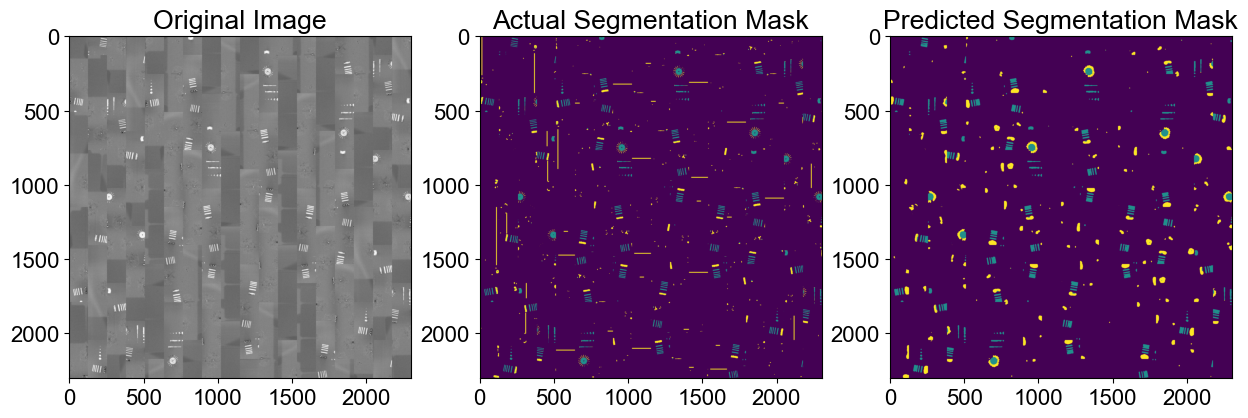

000436
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step
MeanIoU= 0.611


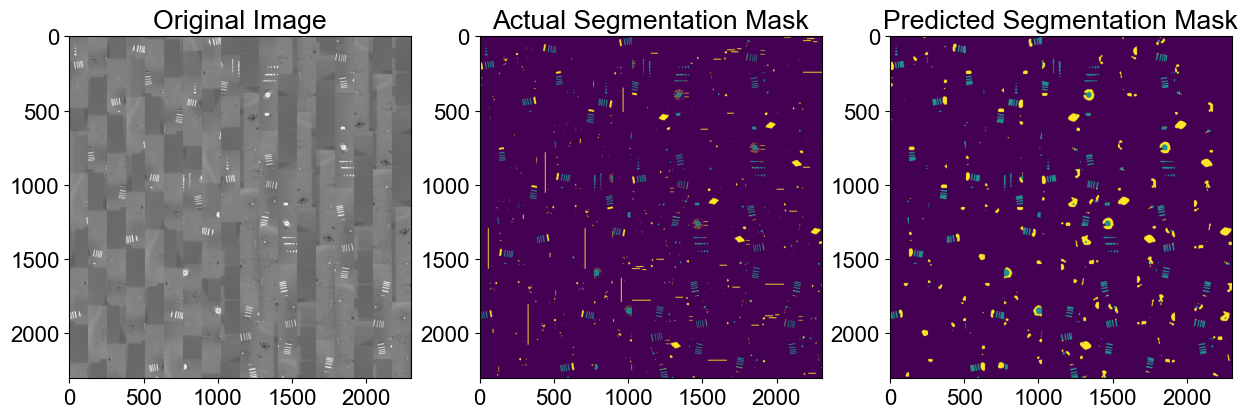

000437
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 6750208 values, but the requested shape requires a multiple of 589824 [Op:Reshape]

In [9]:
fl_model = model

visualize_results_testset(fl_model, imageDictTest, segMaskDictTest,
                              testClients, clientIdentifierDict)